# Alexnet Architecture

AlexNet is the name of a convolutional neural network, invented by **Alex Krizhevsky**, **Ilya Sutskever** and **Geoffrey Hinton**. AlexNet has had a large impact on the field of machine learning, specifically in the application of deep learning to machine vision. As of 2018 it has been cited over 25,000 times.

AlexNet competed in the [ImageNet Large Scale Visual Recognition Challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) in 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. The original paper's primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of GPUs during training.

AlexNet contained eight layers; the first five were convolutional layers, and the last three were fully connected layers. It used the non-saturating `ReLU` activation function, which showed improved training performance over `tanh` and `sigmoid`.

![](https://github.com/Koderunners/Convolutional-Neural-Networks/blob/master/Images/Alexnet.png)


The current implementation has been made using Tensorflow which utilizes 6 GB of Nvidia Tesla K80 GPU provided in Kaggle Kernels. This kernel was written by [Soumik Rakshit](https://www.kaggle.com/soumikrakshit) and [Sohom Dey](https://www.kaggle.com/sohom17d).

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import cv2, os

## Read Dataset

In [3]:
train_dir = '../input/asl_alphabet_train/asl_alphabet_train/'
train_folders = os.listdir(train_dir)
test_dir = '../input/asl_alphabet_test/asl_alphabet_test/'
test_files = os.listdir(test_dir)

In [4]:
x_train, y_train = [], []
for folder in train_folders:
    files = os.listdir(train_dir + folder)
    print('Reading images from ' + train_dir + folder + '/ ...')
    for file in files[:1000]:
        img = cv2.imread(train_dir + folder + '/' + file)
        img = cv2.resize(img, (227, 227))
        x_train.append(img)
        y_train.append(folder)

Reading images from ../input/asl_alphabet_train/asl_alphabet_train/F/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/V/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/Q/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/I/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/N/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/W/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/D/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/C/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/A/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/E/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/X/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/Y/ ...
Reading images from ../input/asl_alphabet_train/asl_alphabet_train/K/ ...
Reading images from ../input/asl_alpha

In [5]:
len(x_train), x_train[0].shape

(29000, (227, 227, 3))

In [6]:
len(y_train)

29000

In [7]:
x_test, y_test = [], []
for file in test_files:
    img = cv2.imread(test_dir + file)
    img = cv2.resize(img, (227, 227))
    x_test.append(img)
    y_test.append(file.split('_')[0])

In [8]:
len(x_test), x_test[0].shape

(28, (227, 227, 3))

In [9]:
len(y_test)

28

## Data Preprocessing

In [10]:
# LabelEncoding
y_test_encoded = np.array(list(range(len(y_test))))
y_train_encoded = np.array([y_test.index(i) if i != 'del' else 29 for i in y_train])

In [11]:
y_test_encoded = np.eye(30)[y_test_encoded]
y_train_encoded = np.eye(30)[y_train_encoded]

In [12]:
y_train_encoded.shape, y_test_encoded.shape

((29000, 30), (28, 30))

## Data Visualization

In [13]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [14]:
def display_images(data, title, display_label = True):
    x, y = data
    fig, axes = plt.subplots(2, 6, figsize = (18, 5))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i])
        if display_label:
            ax.set_xlabel(y[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

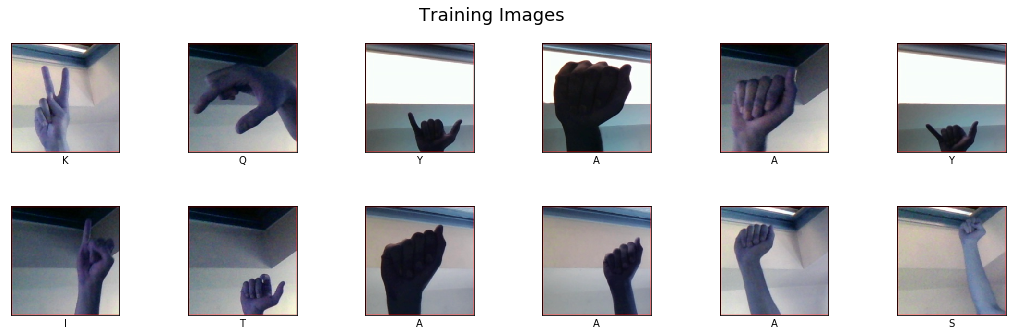

In [15]:
display_images(next_batch(12, x_train, y_train), 'Training Images')

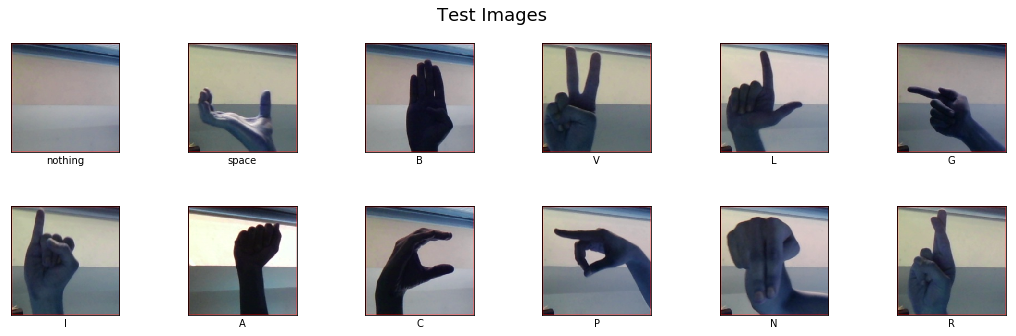

In [16]:
display_images(next_batch(12, x_test, y_test), 'Test Images')

## Alexnet Model

In [17]:
# Training Hyperparameters
learning_rate = 0.001
epochs = 5000
batch_size = 128
display_step = 200

In [18]:
height = 227
width = 227
n_channels = 3
n_classes = 30

In [19]:
X = tf.placeholder(tf.float32, shape = [None, height, width, n_channels])
Y = tf.placeholder(tf.float32, shape = [None, n_classes])

In [20]:
weights = {
    # Convolutional Layer 1: 11x11 filters, 3 input channels, 96 output channels
    'w1' : tf.Variable(tf.random_normal([11, 11, 3, 96])), 
    # Convolutional Layer 2: 5x5 filters, 96 input channels, 256 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 96, 256])),
    # Convolutional Layer 3: 3x3 filters, 256 input channels, 384 output channels
    'w3' : tf.Variable(tf.random_normal([3, 3, 256, 384])),
    # Convolutional Layer 4: 3x3 filters, 384 input channels, 384 output channels
    'w4' : tf.Variable(tf.random_normal([3, 3, 384, 384])),
    # Convolutional Layer 5: 3x3 filters, 384 input channels, 256 output channels
    'w5' : tf.Variable(tf.random_normal([3, 3, 384, 256])),
    # Fully Connected Layer 1: 9216 input channels, 4096 output channels
    'w6' : tf.Variable(tf.random_normal([9216, 4096])),
    # Fully Connected Layer 2: 4096 input channels, 4096 output channels
    'w7' : tf.Variable(tf.random_normal([4096, 4096])),
    # Fully Connected Layer 3: 4096 input channels, 30(number of classes) output channels
    'w8' : tf.Variable(tf.random_normal([4096, n_classes]))
}

In [21]:
biases = {
    'b1' : tf.Variable(tf.random_normal([96])),
    'b2' : tf.Variable(tf.random_normal([256])),
    'b3' : tf.Variable(tf.random_normal([384])),
    'b4' : tf.Variable(tf.random_normal([384])),
    'b5' : tf.Variable(tf.random_normal([256])),
    'b6' : tf.Variable(tf.random_normal([4096])),
    'b7' : tf.Variable(tf.random_normal([4096])),
    'b8' : tf.Variable(tf.random_normal([n_classes]))
}

In [22]:
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1, padding = 'SAME'):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding = padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [23]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k = 2, padding = 'VALID'):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = padding)

In [24]:
def alexnet(x, w, b):
    x = tf.reshape(x, shape = [-1, 227, 227, 3])
    
    # Layer 1
    conv1 = conv2d(x, w['w1'], b['b1'], strides = 4, padding = 'VALID') # Convolution
    conv1 = maxpool2d(conv1) # Pooling
    
    # Layer 2
    conv2 = conv2d(conv1, w['w2'], b['b2']) # Convolution
    conv2 = maxpool2d(conv2) # Pooling
    
    # Layer 3
    conv3 = conv2d(conv2, w['w3'], b['b3']) # Convolution
    
    # Layer 4
    conv4 = conv2d(conv3, w['w4'], b['b4']) # Convolution
    
    # Layer 5
    conv5 = conv2d(conv4, w['w5'], b['b5']) # Convolution
    conv5 = maxpool2d(conv5) # Pooling
    
    # Layer 6
    fc1 = tf.reshape(conv5, [-1, weights['w6'].get_shape().as_list()[0]]) # Channel Reshape
    fc1 = tf.add(tf.matmul(fc1, w['w6']), b['b6']) # Linear Function
    fc1 = tf.nn.relu(fc1) # Activation Function
    
    # Layer 7
    fc2 = tf.add(tf.matmul(fc1, w['w7']), b['b7']) # Linear Function
    fc2 = tf.nn.relu(fc2) # Activation Function
    
    # Layer 8
    out = tf.add(tf.matmul(fc2, w['w8']), b['b8']) # Linear Function
    
    return out

In [25]:
logits = alexnet(X, weights, biases) # Forward Propagation

In [26]:
# Cost Function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
# Training Operation
train_op = optimizer.minimize(loss_op)

In [27]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [28]:
init = tf.global_variables_initializer()

## Training the Alexnet

In [29]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, x_train, y_train_encoded)
        # Running Optimizer
        sess.run(train_op, feed_dict = { X : _x, Y : _y })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y })
            loss = loss
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    W = sess.run(weights)
    B = sess.run(biases)
    print('-' * 70)
    print('\nOptimization Finished\n')

Epoch 200, Cost: 15033446000000.0, Accuracy: 47.65625 %
Epoch 400, Cost: 5968476000000.0, Accuracy: 66.40625 %
Epoch 600, Cost: 3882934000000.0, Accuracy: 77.34375 %
Epoch 800, Cost: 2003400900000.0, Accuracy: 86.71875 %
Epoch 1000, Cost: 1773139400000.0, Accuracy: 82.03125 %
Epoch 1200, Cost: 1078498400000.0, Accuracy: 89.0625 %
Epoch 1400, Cost: 1459129200000.0, Accuracy: 91.40625 %
Epoch 1600, Cost: 348440170000.0, Accuracy: 92.1875 %
Epoch 1800, Cost: 253812340000.0, Accuracy: 95.3125 %
Epoch 2000, Cost: 350462900000.0, Accuracy: 96.09375 %
Epoch 2200, Cost: 163520450000.0, Accuracy: 97.65625 %
Epoch 2400, Cost: 140487490000.0, Accuracy: 95.3125 %
Epoch 2600, Cost: 419934670000.0, Accuracy: 96.875 %
Epoch 2800, Cost: 361814230000.0, Accuracy: 96.09375 %
Epoch 3000, Cost: 111608170000.0, Accuracy: 96.875 %
Epoch 3200, Cost: 49408900000.0, Accuracy: 96.09375 %
Epoch 3400, Cost: 331359260000.0, Accuracy: 94.53125 %
Epoch 3600, Cost: 78999620000.0, Accuracy: 98.4375 %
Epoch 3800, Cost:

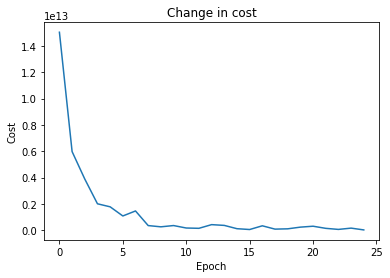

In [30]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

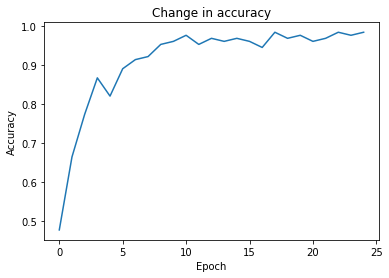

In [31]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Saving Optimized Parameters

In [32]:
for key in weights.keys():
    weights[key] = tf.Variable(W[key])
    np.save(key, W[key])

In [33]:
for key in biases.keys():
    biases[key] = tf.Variable(B[key])
    np.save(key, B[key])

## Checking Accuracy

In [34]:
logits = alexnet(X, weights, biases)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

In [35]:
with tf.Session() as sess:
    acc = []
    sess.run(init)
    for i in range(100, 29001, 100):
        acc.append(sess.run(accuracy, feed_dict = { X : x_train[i - 100 : i], Y : y_train_encoded[i - 100 : i] }))
print('Accuracy on Training Data: ' + str(sum(acc) * 100 / len(acc)) + '%')

Accuracy on Training Data: 96.12758661138601%


In [36]:
with tf.Session() as sess:
    sess.run(init)
    y_pred = sess.run(logits, feed_dict = { X : x_test })
    acc = sess.run(accuracy, feed_dict = { X : x_test, Y : y_test_encoded }) * 100
print('Accuracy on Test Data: ' + str(acc) + '%')

Accuracy on Test Data: 100.0%


## Visualizing Predictions

In [37]:
y_pred = [y_test[list(i).index(max(list(i)))] for i in y_pred]

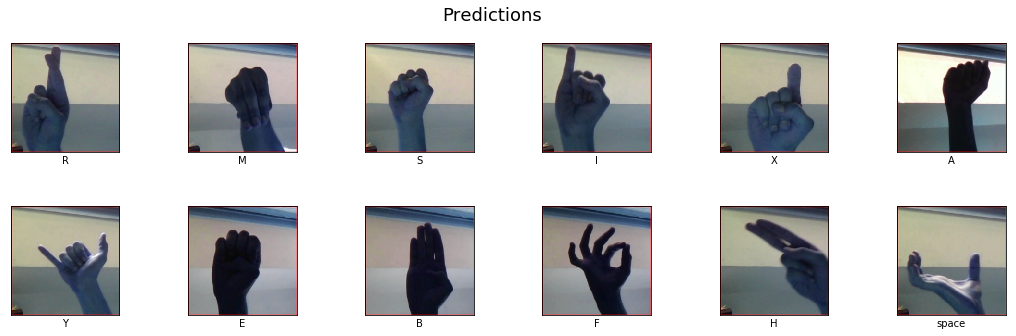

In [38]:
display_images(next_batch(12, x_test, y_pred), 'Predictions')